<a href="https://colab.research.google.com/github/NeuromatchAcademy/course-content/blob/master/tutorials/W1D2_ModelingPractice/student/W1D2_Tutorial1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neuromatch Academy: Week1, Day 2, Tutorial 1


#Tutorial objectives
Yesterday you gained some understanding of what models can buy us in neuroscience. But how do you build a model? Today, we will try to clarify the process of computational modeling, by building a simple model.

We will investigate a simple phenomena, working through the 10 steps of modeling ([Blohm et al., 2019](https://doi.org/10.1523/ENEURO.0352-19.2019)) in two notebooks: 

**Framing the question**
1. finding a phenomenon and a question to ask about it
2. understanding the state of the art
3. determining the basic ingredients
4. formulating specific, mathematically defined hypotheses
**Implementing the model**
5. selecting the toolkit
6. planning the model
7. implementing the model
**Model testing**
8. completing the model
9. testing and evaluating the model
**Publishing**
10. publishing models

Tutorial 1 (this notebook) will covers steps 1-5 and part 2 will cover steps 6-10.

This tutorial contains both coding and thinking activities.
Doing both are essential for success. 

**TD**: All activities you should perform are labeled with **TD#.#**, which stands for "To Do", micro-tutorial number, activity number. They can be found in the Table of Content on the left side of the notebook. Make sure you complete all within a section before moving on!

**Run**: Some code chunks' names start with "Run to ... (do something)".  These chunks are purely to produce a graph or calculate a number. You do not need to look at or understand the code in those chunks.

Setup: Imports, helper functions, and data retreival



Please run the following **3** chunks to have functions and data available.

#Setup: Imports, helper functions, and data retreival


In [1]:
#@title Imports
#@markdown Import libraries so you can use their functions

import time                        # import time 
import numpy as np                 # import numpy
import scipy as sp                 # import scipy
from scipy.stats import gamma      # import gamma distribution
import math                        # import basic math functions
import random                      # import basic random number generator functions

import matplotlib.pyplot as plt    # import matplotlib
from IPython import display        
from scipy.signal import medfilt


In [2]:
#@title Helper functions
#@markdown Helper functions simplify the code that you need to write.

def my_moving_window(x, window=3, FUN=np.mean):
    '''
    Calculates a moving estimate for a signal

    Args:
        x (numpy.ndarray): a vector array of size N
        window (int): size of the window, must be a positive integer
        FUN (function): the function to apply to the samples in the window

    Returns:
        (numpy.ndarray): a vector array of size N, containing the moving average
        of x, calculated with a window of size window

    There are smarter and faster solutions (e.g. using convolution) but this 
    function shows what the output really means. This function skips NaNs, and 
    should not be susceptible to edge effects: it will simply use
    all the  available samples, which means that close to the edges of the 
    signal or close to NaNs, the output will just be based on fewer samples. By
    default, this function will apply a mean to the samples in the window, but 
    this can be changed to be a max/min/median or other function that returns a 
    single numeric value based on a sequence of values.
    '''

    # if data is a matrix, apply filter to each row:
    if len(x.shape) == 2:
        output = np.zeros(x.shape)
        for rown in range(x.shape[0]):
            output[rown,:] = my_moving_window(x[rown,:],window=window,FUN=FUN)
        return output

    # make output array of the same size as x:
    output = np.zeros(x.size)

    # loop through the signal in x
    for samp_i in range(x.size):

        values = []

        # loop through the window:
        for wind_i in range(int(-window), 1):

            if ((samp_i+wind_i) < 0) or (samp_i+wind_i) > (x.size - 1):
                # out of range
                continue
            
            # sample is in range and not nan, use it:
            if not(np.isnan(x[samp_i+wind_i])):
                values += [x[samp_i+wind_i]]
        
        # calculate the mean in the window for this point in the output:
        output[samp_i] = FUN(values)

    return output


def my_plot_percepts(datasets=None, plotconditions=False):

    if isinstance(datasets,dict):
        # try to plot the datasets
        # they should be named...
        # 'expectations', 'judgments', 'predictions'

        fig = plt.figure(figsize=(8, 8)) # set aspect ratio = 1? not really

        plt.ylabel('perceived self motion [m/s]')
        plt.xlabel('perceived world motion [m/s]')
        plt.title('perceived velocities')
        
        # loop through the entries in datasets
        # plot them in the appropriate way
        for k in datasets.keys():
            if k == 'expectations':
                
                expect = datasets[k]
                plt.scatter(expect['world'],expect['self'],marker='*',color='xkcd:green',label='my expectations')

            elif k == 'judgments':
                
                judgments = datasets[k]

                for condition in np.unique(judgments[:,0]):
                    c_idx = np.where(judgments[:,0] == condition)[0]
                    cond_self_motion = judgments[c_idx[0],1]
                    cond_world_motion = judgments[c_idx[0],2]
                    if cond_world_motion == -1 and cond_self_motion == 0:
                        c_label = 'world-motion condition judgments' 
                    elif cond_world_motion == 0 and cond_self_motion == 1:
                        c_label = 'self-motion condition judgments' 
                    else:
                        c_label = 'condition [%d] judgments'%condition
                    
                    plt.scatter(judgments[c_idx,3],judgments[c_idx,4], label=c_label, alpha=0.2)

            elif k == 'predictions':
                
                predictions = datasets[k]

                for condition in np.unique(predictions[:,0]):
                    c_idx = np.where(predictions[:,0] == condition)[0]
                    cond_self_motion = predictions[c_idx[0],1]
                    cond_world_motion = predictions[c_idx[0],2]
                    if cond_world_motion == -1 and cond_self_motion == 0:
                        c_label = 'predicted world-motion condition' 
                    elif cond_world_motion == 0 and cond_self_motion == 1:
                        c_label = 'predicted self-motion condition' 
                    else:
                        c_label = 'condition [%d] prediction'%condition
                    
                    plt.scatter(predictions[c_idx,4],predictions[c_idx,3], marker='x', label=c_label)

            else:
                print("datasets keys should be 'hypothesis', 'judgments' and 'predictions'")

            
        if plotconditions:
            # this code is simplified but only works for the dataset we have:
            plt.scatter([1],[0],marker='<',facecolor='none',edgecolor='xkcd:black',linewidths=2,label='world-motion stimulus',s=80)
            plt.scatter([0],[1],marker='>',facecolor='none',edgecolor='xkcd:black',linewidths=2,label='self-motion stimulus',s=80)

        plt.legend(facecolor='xkcd:white')
        plt.show()

    else:
        if datasets is not None:
            print('datasets argument should be a dict')
            raise TypeError

def my_plot_motion_signals():
    dt = 1/10
    a = gamma.pdf( np.arange(0,10,dt), 2.5, 0 )
    t = np.arange(0,10,dt)
    v = np.cumsum(a*dt)

    fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, sharex='col', sharey='row', figsize=(14,6))
    fig.suptitle('Sensory ground truth')

    ax1.set_title('world-motion condition')
    ax1.plot(t,-v,label='visual [$m/s$]')
    ax1.plot(t,np.zeros(a.size),label='vestibular [$m/s^2$]')
    ax1.set_xlabel('time [s]')
    ax1.set_ylabel('motion')
    ax1.legend(facecolor='xkcd:white')

    ax2.set_title('self-motion condition')
    ax2.plot(t,-v,label='visual [$m/s$]')
    ax2.plot(t,a,label='vestibular [$m/s^2$]')
    ax2.set_xlabel('time [s]')
    ax2.set_ylabel('motion')
    ax2.legend(facecolor='xkcd:white')

    plt.show()



def my_plot_sensorysignals(judgments, opticflow, vestibular, returnaxes=False, addaverages=False):
    
    wm_idx = np.where(judgments[:,0] == 0)
    sm_idx = np.where(judgments[:,0] == 1)
     
    opticflow = opticflow.transpose()
    wm_opticflow = np.squeeze(opticflow[:,wm_idx])
    sm_opticflow = np.squeeze(opticflow[:,sm_idx])
    
    vestibular = vestibular.transpose()
    wm_vestibular = np.squeeze(vestibular[:,wm_idx])
    sm_vestibular = np.squeeze(vestibular[:,sm_idx])
    
    X = np.arange(0,10,.1)
    
    fig, my_axes = plt.subplots(nrows=2, ncols=2, sharex='col', sharey='row', figsize=(15,10))
    fig.suptitle('Sensory signals')

    my_axes[0][0].plot(X,wm_opticflow, color='xkcd:light red', alpha=0.1)
    my_axes[0][0].plot([0,10], [0,0], ':', color='xkcd:black')
    if addaverages:
        my_axes[0][0].plot(X,np.average(wm_opticflow, axis=1), color='xkcd:red', alpha=1)
    my_axes[0][0].set_title('optic-flow in world-motion condition')
    my_axes[0][0].set_ylabel('[motion]')

    my_axes[0][1].plot(X,sm_opticflow, color='xkcd:azure', alpha=0.1)
    my_axes[0][1].plot([0,10], [0,0], ':', color='xkcd:black')
    if addaverages:
        my_axes[0][1].plot(X,np.average(sm_opticflow, axis=1), color='xkcd:blue', alpha=1)
    my_axes[0][1].set_title('optic-flow in self-motion condition')

    my_axes[1][0].plot(X,wm_vestibular, color='xkcd:light red', alpha=0.1)
    my_axes[1][0].plot([0,10], [0,0], ':', color='xkcd:black')
    if addaverages:
        my_axes[1][0].plot(X,np.average(wm_vestibular, axis=1), color='xkcd:red', alpha=1)
    my_axes[1][0].set_title('vestibular signal in world-motion condition')
    my_axes[1][0].set_xlabel('time [s]')
    my_axes[1][0].set_ylabel('[motion]')

    my_axes[1][1].plot(X,sm_vestibular, color='xkcd:azure', alpha=0.1)
    my_axes[1][1].plot([0,10], [0,0], ':', color='xkcd:black')
    if addaverages:
        my_axes[1][1].plot(X,np.average(sm_vestibular, axis=1), color='xkcd:blue', alpha=1)
    my_axes[1][1].set_title('vestibular signal in self-motion condition')
    my_axes[1][1].set_xlabel('time [s]')

    if returnaxes:
        return my_axes
    else:
        plt.show()

def my_plot_thresholds(thresholds, world_prop, self_prop, prop_correct):

    plt.figure(figsize=(12,8))
    plt.title('threshold effects')
    plt.plot([min(thresholds),max(thresholds)],[0,0],':',color='xkcd:black')
    plt.plot([min(thresholds),max(thresholds)],[0.5,0.5],':',color='xkcd:black')
    plt.plot([min(thresholds),max(thresholds)],[1,1],':',color='xkcd:black')
    plt.plot(thresholds, world_prop, label='world motion condition')
    plt.plot(thresholds, self_prop, label='self motion condition')
    plt.plot(thresholds, prop_correct, color='xkcd:purple', label='correct classification')
    plt.xlabel('threshold')
    plt.ylabel('proportion correct or classified as self motion')
    plt.legend(facecolor='xkcd:white')
    plt.show()

def my_plot_predictions_data(judgments, predictions):

    conditions = np.concatenate((np.abs(judgments[:,1]),np.abs(judgments[:,2])))
    veljudgmnt = np.concatenate((judgments[:,3],judgments[:,4]))
    velpredict = np.concatenate((predictions[:,3],predictions[:,4]))

    # self:
    conditions_self = np.abs(judgments[:,1])
    veljudgmnt_self = judgments[:,3]
    velpredict_self = predictions[:,3]

    # world:
    conditions_world = np.abs(judgments[:,2])
    veljudgmnt_world = judgments[:,4]
    velpredict_world = predictions[:,4]

    fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, sharey='row', figsize=(12,5))

    ax1.scatter(veljudgmnt_self,velpredict_self, alpha=0.2)
    ax1.plot([0,1],[0,1],':',color='xkcd:black')
    ax1.set_title('self-motion judgments')
    ax1.set_xlabel('observed')
    ax1.set_ylabel('predicted')

    ax2.scatter(veljudgmnt_world,velpredict_world, alpha=0.2)
    ax2.plot([0,1],[0,1],':',color='xkcd:black')
    ax2.set_title('world-motion judgments')
    ax2.set_xlabel('observed')
    ax2.set_ylabel('predicted')

    plt.show()

In [3]:
#@title Figure parameters
#@markdown This cell defines the way that figures will appear by default.

%matplotlib inline
#%config InlineBackend.figure_format = 'retina'


fig_w, fig_h = (12, 8)
plt.rcParams.update({'figure.figsize': (fig_w, fig_h)})
plt.style.use('ggplot')


In [4]:
#@title Data retrieval (The data generated below needs to be put on OSF, and this cell deleted)
#@markdown This cell downloads the example dataset that we will use in this tutorial.

def my_simulate_data(repetitions=100, conditions=[(0,-1),(+1,0)] ):
    """
    Generate simulated data for this tutorial. You do not need to run this 
    yourself.

    Args:
      repetitions: (int) number of repetitions of each condition (default: 30)
      conditions: list of 2-tuples of floats, indicating the self velocity and 
                  world velocity in each condition (default: returns data that is
                  good for exploration: [(-1,0),(0,+1)] but can be flexibly
                  extended)

    The total number of trials used (ntrials) is equal to:
    repetitions * len(conditions)

    Returns:
      dict with three entries:
        'judgments':  ntrials * 5 matrix
        'opticflow':  ntrials * 100 matrix
        'vestibular': ntrials * 100 matrix
    
    The default settings would result in data where first 30 trials reflect a
    situation where the world (other train) moves in one direction, supposedly
    at 1 m/s (perhaps to the left: -1) while the participant does not move at
    all (0), and 30 trials from a second condition, where the world does not 
    move, while the participant moves with 1 m/s in the opposite direction from
    where the world is moving in the first condition (0,+1). The optic flow 
    should be the same, but the vestibular input is not.

    """
    
    # reproducible output
    np.random.seed(1937)
    
    # set up some variables:
    ntrials    = repetitions * len(conditions)

    # the following arrays will contain the simulated data:
    judgments  = np.empty(shape=(ntrials,5))
    opticflow  = np.empty(shape=(ntrials,100))
    vestibular = np.empty(shape=(ntrials,100))
    

    # acceleration:
    a = gamma.pdf(np.arange(0,10,.1), 2.5, 0 )
    # divide by 10 so that velocity scales from 0 to 1 (m/s)

    # max acceleration ~ .308 m/s^2
    # not realistic! should be about 1/10 of that

    # velocity:
    v = np.cumsum(a*.1)
    # position: (not necessary)
    #x = np.cumsum(v)
    
    #################################
    # REMOVE ARBITRARY SCALING & CORRECT NOISE PARAMETERS

    vest_amp = 1
    optf_amp = 1

    # we start at the first trial:
    trialN = 0

    # we start with only a single velocity, but it should be possible to extend this
    for conditionno in range(len(conditions)):

        condition = conditions[conditionno]

        for repetition in range(repetitions):
            
            # 

            # generate optic flow signal
            OF = v * np.diff(condition)                             # optic flow: difference between self & world motion
            OF = (OF * optf_amp)                                    # fairly large spike range
            OF = OF + (np.random.randn(len(OF)) * .1)               # adding noise
            
            # generate vestibular signal
            VS = a * condition[0]                                   # vestibular signal: only self motion
            VS = (VS * vest_amp)                                    # less range
            VS = VS + (np.random.randn(len(VS)) * 1.)               # acceleration is a smaller signal, what is a good noise level?
            
            # store in matrices, corrected for sign
            #opticflow[trialN,:] = OF * -1 if (np.sign(np.diff(condition)) < 0) else OF
            #vestibular[trialN,:] = VS * -1 if (np.sign(condition[1]) < 0) else VS
            opticflow[trialN,:], vestibular[trialN,:] = OF, VS

            #########################################################
            
            # store conditions in judgments matrix:
            judgments[trialN,0:3] = [ conditionno, condition[0], condition[1] ]
            
            # vestibular SD: 1.0916052957046194 and 0.9112684509277528
            # visual SD: 0.10228834313079663 and 0.10975472557444346

            # generate judgments:
            if (abs(np.average(np.cumsum(medfilt(VS/vest_amp,5)*.1)[70:90])) < 1):
                ###########################
                # NO self motion detected
                ###########################
                selfmotion_weights  = np.array([.01,.01])  # there should be low/no self motion
                worldmotion_weights = np.array([.01,.99])  # world motion is dictated by optic flow
                

            else:
                ########################
                # self motion DETECTED
                ########################
                #if (abs(np.average(np.cumsum(medfilt(VS/vest_amp,15)*.1)[70:90]) - np.average(medfilt(OF,15)[70:90])) < 5):
                if True:
                    ####################
                    # explain all self motion by optic flow
                    selfmotion_weights  = np.array([.01,.99])  # there should be lots of self motion, but determined by optic flow
                    worldmotion_weights = np.array([.01,.01])  # very low world motion?
                else:
                    # we use both optic flow and vestibular info to explain both
                    selfmotion_weights  = np.array([ 1, 0])    # motion, but determined by vestibular signal
                    worldmotion_weights = np.array([ 1, 1])  # very low world motion?
                
            # 
            integrated_signals = np.array([
                                           np.average( np.cumsum(medfilt(VS/vest_amp,15))[90:100]*.1 ), 
                                           np.average((medfilt(OF/optf_amp,15))[90:100]) 
                                           ])
            selfmotion  = np.sum(integrated_signals * selfmotion_weights)
            worldmotion = np.sum(integrated_signals * worldmotion_weights)
            #print(worldmotion,selfmotion)

            judgments[trialN,3] = abs(selfmotion)
            judgments[trialN,4] = abs(worldmotion)
            
            # this ends the trial loop, so we increment the counter:
            trialN += 1
                
    return {'judgments':judgments, 
            'opticflow':opticflow, 
            'vestibular':vestibular}

simulated_data = my_simulate_data()

judgments = simulated_data['judgments']
opticflow = simulated_data['opticflow']
vestibular = simulated_data['vestibular']


#  Micro-tutorial 1 - investigate the phenomenon and ask questions


Video available at https://youtube.com/watch?v=c9DHjcMJ5Kk


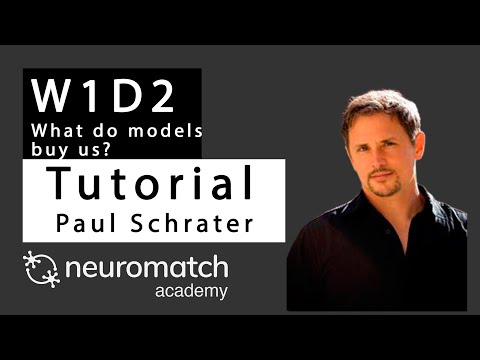

In [5]:
#@title Video: ask questions
from IPython.display import YouTubeVideo
video = YouTubeVideo(id='c9DHjcMJ5Kk', width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)
video


**Goal**: formulate a good question!

### Background: The train illusion
You have likely experienced the train illusion: You enter the train (everything is immobile) and view a train next to you through the window from your seat. Now you see motion through the window (optic flow) but it can be unclear who’s moving? The train you're on? The train next door? Or both? Your perception of motion typically takes one form. This false/illusory perception of self-motion when in reality there is world-motion (the train next to you is moving) is known as the train illusion. 

Watch these videos as a reminder: [Relative velocity of trains](https://youtu.be/AKhvqO5UBsA) and [masstransitscope](https://untappedcities.com/2016/03/14/video-masstransitscope-a-zoetrope-art-piece-in-an-abandoned-nyc-subway-station/).
> When watching the first movie full screen, you might experience the illusion.

Sometimes we perceive our own train to be moving and sometimes the other train. How come our perception is ambiguous?

We will build a simple model (that explains train illusions) with the goal _to learn about the process of model building_ (i.e.: not to explain train illusions or get a correct model). To keep this manageable, we use a _simulated_ data set. Imagine we get data from an experimentalist who collected judgments on self motion and world motion, in two conditions. One where there was only world motion, and one where there was only self motion. In either case, the velocity increased from 0 to 1 m/s across 10 seconds with the same (fairly low) acceleration. Each of these conditions was recorded 100 times:

![illustration of the conditions](https://deniseh.lab.yorku.ca/files/2020/06/NMA-W1D2_fig01.jpg)

Participants sit very still during the trials and at the end of each 10 s trial they are given two button pressers, one to indicate that they though there was self-motion and another to indicate that they though the world was moving _at the end of the interval_. They are also asked to estimate the velocity of the reported self or world motion.

**Considerations:**
Imagine you plot the world motion data on the x-axis, and the self-motion data on the y-axis.
* in the self-motion condition, where on this plot should judgment of self-motion and world-motion lie?
* if only world-motion, where should judgment data lie?
* what happens if there is an illusion of self-motion?


### **TD 1.1**: Form expectations about the experiment, using the phenomena
In the experiment there are true velocities of self and world motion, and we get the participants _judgments_ of those velocities. Sometimes the participants will be correct, but sometimes they will experience a train illusions. Which velocity judgment pairs do you think will occur in this experiment? In which conditions does the illusion occur? What will the judgments look like if there is an illusion? In the Python chunk below, you should put some numbers that represent your expectations. Remember the judgments are exclusive, you either experience world motion (world_vel_exp > 0) or self motion (self_vel_exp > 0), but not both on the same trial. Also remember that judgements are unsigned, so use positive numbers in m/s. Replace the question marks, and add, remove and change values in the two lists until you are satisfied.

**Create Expectations**

In [6]:
# Create Expectations
###################################################################
## Change the values in the lists below. 
## These act as X and Y coordinates for a scatter plot, 
## so make sure the lists match in length.
## the provided code will plot your expectations
################################################################### 

#To complete the exercise, uncomment the code below and fill in the missing parts (?)

#world_vel_exp = [0, 1, ?, ?]
#self_vel_exp  = [?, ?, 0, 1]

#expectations = {'world':world_vel_exp, 'self':self_vel_exp}
#my_plot_percepts(datasets={'expectations':expectations})

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/master//tutorials/W1D2_ModelingPractice/solutions/W1D2_Tutorial1_Solution_cc8f4397.py)

*Example output:*

<img alt='Solution hint' align='left' width=516 height=519 src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/tutorials/W1D2_ModelingPractice/static/W1D2_Tutorial1_Solution_cc8f4397_0.png>



### **TD 1.2**: Compare Expectations to Data
The data from our experiment is in a matrix called `judgments`, where each row indicates a trial, and the columns represent the following variables.

Columns in `judgments' matrix:
0. condition number (for bookkeeping)
1. self velocity stimulus (m/s, directional)
2. world velocity stimulus (m/s, directional)
3. self motion judgment (m/s, not directional)
4. world motion judgment (m/s, not directional)

The condition number can be 0 (world-motion condition, first 100 rows) or 1 (self-motion condition, last 100 rows). Column 1 (self-motion velocity) is 0 for the world-motion condition, but 1 for the self-motion condition. Column 2 (world-motion velocity) is -1 for the world-motion condition, but 0 for the self-motion condition. These three columns just describe the conditions from the _"experiment"_ we did, and you will not have to use them.

The motion judgements (columns 3 and 4) are the participants judgments of the self-motion velocity and world-motion velocity respectively, and should show the illusion.  Both are in unsigned m/s. So here we will plot the judgment data, along with the true motion of the stimuli in the experiment:


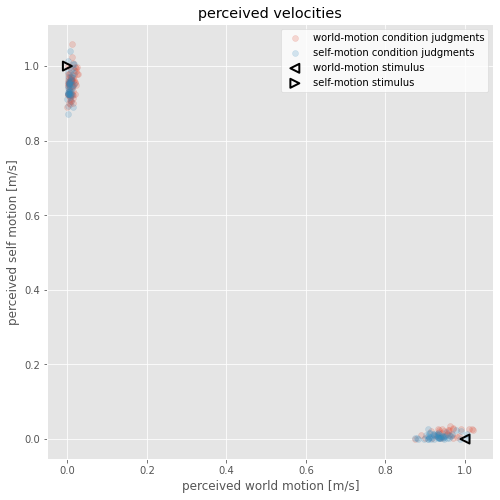

In [8]:
#@title Run to plot perceptual judgments
my_plot_percepts(datasets={'judgments':judgments}, 
                 plotconditions=True)

### **TD 1.3**: Think about what the data is saying, by answering these questions:
* How does it differ from your initial expectations? 
* Where are the clusters of data, roughly?
* What does it mean that the some of the judgments from the world-motion condition are close to the self-motion stimulus and vice versa?
* Why are there no data points in the middle?
* What aspects of the data require explanation?

#Micro-tutorial 2 - understanding background information


Video available at https://youtube.com/watch?v=yMb9IFH8gg0


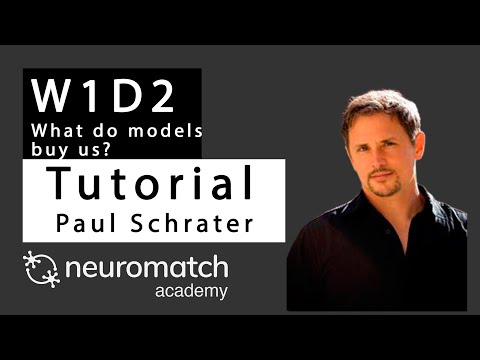

In [9]:
#@title Video: Background
from IPython.display import YouTubeVideo
video = YouTubeVideo(id='yMb9IFH8gg0', width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)
video

**Goal:** Now that we have an interesting phenomenon, we gather background information which will refine our questions, and we lay the groundwork for developing scientific hypotheses. 

**Background: Motion Sensing**: 
We recall that our self-motion percepts are based on our visual (optic flow) and vestibular (inner ear) sensing. Optic flow is the moving image on the retina caused by either self or world-motion. Vestibular signals are related to bodily self- movements only.

These two signals are used by people to make judgements about their self-motion velocity and the world/train's motion velocity, and when combined can lead to the illusory perceptions of world motion or self motion as in the train illusion. 

While the train illusion is poorly understood, a lot is known about these signals.

**Background: Understanding the stimulus**:
We'll first look at the ground truth which is stimulating the senses in our experiment: the world- and self-motion that the participants were exposed to in the experiment. 

These motion signals can be understood as velocity in $m/s$ (optic flow) and acceleration in $m/s^2$ (vestibular signal). 



These motion signals were used in the experimental conditions:

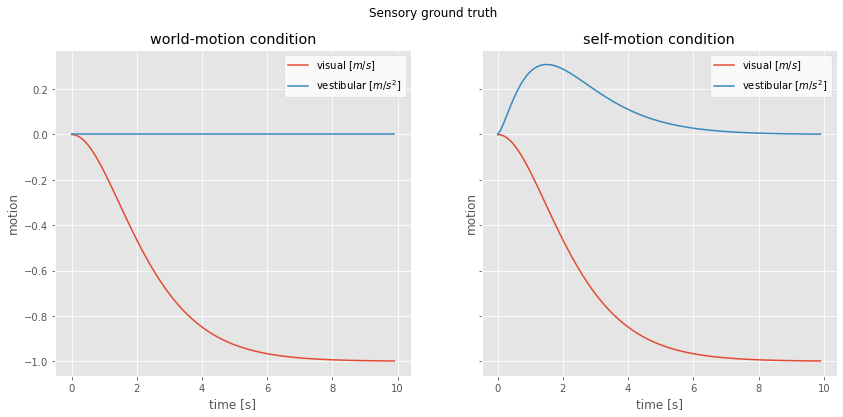

In [10]:
#@title Run to plot motion signals
my_plot_motion_signals()

### **TD 2.1**: Examine the differences between the conditions:
* how are the visual inputs (optic flow) different between the conditions?
* how are the vestibular signals different between the conditions?
* how might the brain use these signals to determine there is self motion?
* how might the brain use these signals to determine there is world motion?

We can see that, in theory, we have enough information to disambiguate self-motion from world-motion using these signals, so there should be no false illusory percepts like the train illusion. Let's go over the logic together:
The visual signal is ambiguous, it will be non-zero when there is either self-motion or world-motion. The vestibular signal is specific, it’s only non-zero when there is self-motion, but it contains little information about world-motion. So combining these two signals should allow us to disambiguate the self-motion condition from the world-motion condition!

* In the world-motion condition: The brain can simply compare the visual and vestibular signals. If there is visual motion AND NOT vestibular motion, it must be that the world is moving but not the body/self = world-motion judgement.
* In the self-motion condition: We can make a similar comparison. If there is both visual signals AND vestibular signals, it must be that the body/self is moving = self-motion judgement.


**Background: Integrating signals**: 

To understand how the vestibular _acceleration_ signal could underlie the perception of self-motion _velocity_, we assume the brain integrates the signal.   This also allows comparing the vestibular signal to the visual signal, by getting them in the same units. 

Since acceleration is the derivative of velocity, we can integrate the vestibular acceleration signal to compare it to the visual velocity signal:

$$v(t) = \int_{0}^T a(t) \cdot dt + v_0$$

> * $a(t)$ is acceleration as a function of time
* $v(t)$ is velocity as a function of time
* $v_0$ is the _constant of integration_ which corresponds in the initial condition of the system at time $0$.

In our experiment $v_0 = 0$, so we can safely leave it out from here on. For other experiments, the initial condition $v_0$ must be **remembered** or **known** - it represents remembering or knowing your motion when the trial starts.  

We can approximate the integral using '_Euler Integration_', or discretizing the acceleration signal into $\Delta t$, and summing over all the areas for each $\Delta t$ starting at time 0 of our signal. The process of keeping a running sum, as done here, is known as cumulative summation.
$$v_t = \sum_{k=0}^t a_k\cdot\Delta t$$
>* $\Delta t$ is equal to the sample interval of our recorded visual and vestibular signals (0.1 s).

In Python, we can use the `np.cumsum()` function on a signal to do definite integration using the Euler method.  

To preserve the right timescale, you should multiply the acceleration signal by $\Delta t$ = 100 ms, or 0.1 s. 

Below is a chunk of code where you should apply the `np.cumsum()` function to the acceleration that was used in our (simulated) experiment: `a` in order to get a velocity signal `v`.  

### **TD 2.2**: Numerically Integrating a signal

**Complete this code, to integrate acceleration**

In [11]:
# Complete the code:
dt = 1/10
a = gamma.pdf(np.arange(0,10,dt), 2.5, 0 )
t = np.arange(0,10,dt)

######################################################
# To complete the exercise, uncomment the code and fill missing parts (???)
#v = np.cumsum(???)


#plt.figure(figsize=(10,6))
#plt.plot(t,a,label='acceleration [$m/s^2$]')
#plt.plot(t,v,label='velocity [$m/s$]')
#plt.xlabel('time [s]')
#plt.ylabel('[motion]')
#plt.legend(facecolor='xkcd:white')
#plt.show()

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/master//tutorials/W1D2_ModelingPractice/solutions/W1D2_Tutorial1_Solution_d5d3d6dd.py)

*Example output:*

<img alt='Solution hint' align='left' width=627 height=390 src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/tutorials/W1D2_ModelingPractice/static/W1D2_Tutorial1_Solution_d5d3d6dd_0.png>



**Background: Sensory signals are noisy**: 

In our experiment, in addition to judgements of world vs self-motion, we also recorded sensory signals of the participant. We will now also look at the sensory signals, by plotting the data. The data come in two matrices:

`opticflow` (with the visual signals)

and

`vestibular` (with the vestibular signals)

In each of the signal matrices _rows_ represent **trials**, while _columns_ are **time samples**. There are 100 columns, representing $10 s$ collected with a 100 ms time bin. 

Here we plot the data representing our 'sensory signals':

* plot optic flow signals for self-motion vs world-motion conditions (should be the same)
* plot vestibular signals for self-motion vs world-motion conditions (should be different)

The x-axis is time in seconds, but the y-axis can be one of several, depending on what you do with the signals: $m/s^2$ (acceleration), $m/s$ (velocity) or $m$ (distance).

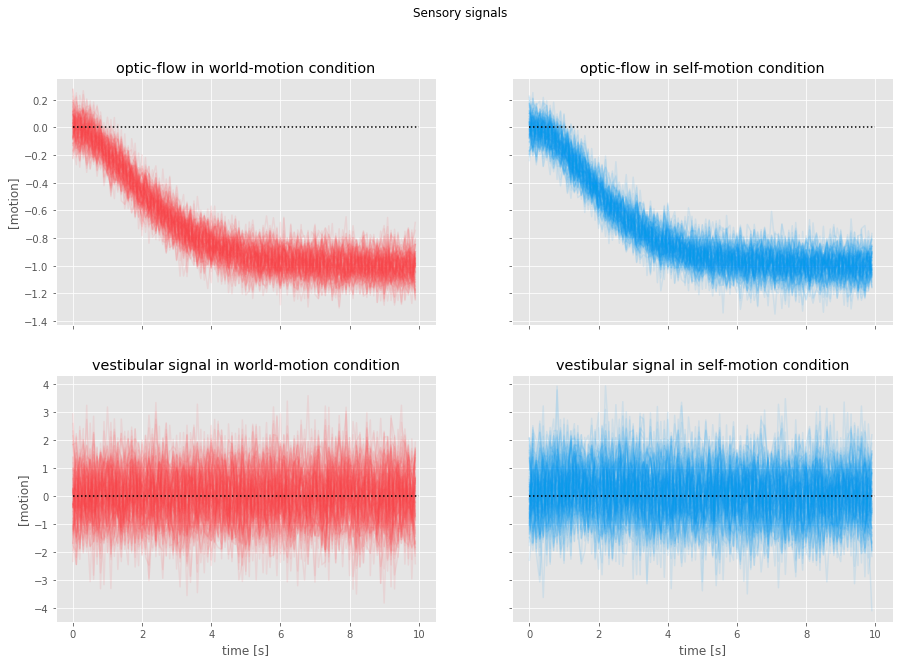

In [13]:
#@title Run to plot raw noisy sensory signals
# signals as they are:
my_plot_sensorysignals(judgments, opticflow, vestibular)


### **TD 2.3**: Understanding the problem of noisy sensory information

**Answer the following questions:**
 * Is this what you expected?
 * In which of the two signals should we be able to see a difference between the conditions?
 * Can we use the data as it is to differentiate between the conditions? 
 * Can we compare the the visual and vestibular motion signals when they're in different units?
 * What would the brain do differentiate the two conditions?


Now that we know how to integrate the vestibular signal to get it into the same unit as the optic flow, we can see if it shows the pattern it should: a flat line in the world-motion condition and the correct velocity profile in the self-motion condition. Run the chunk of Python below to plot the sensory data again, but now with the vestibular signal integrated.


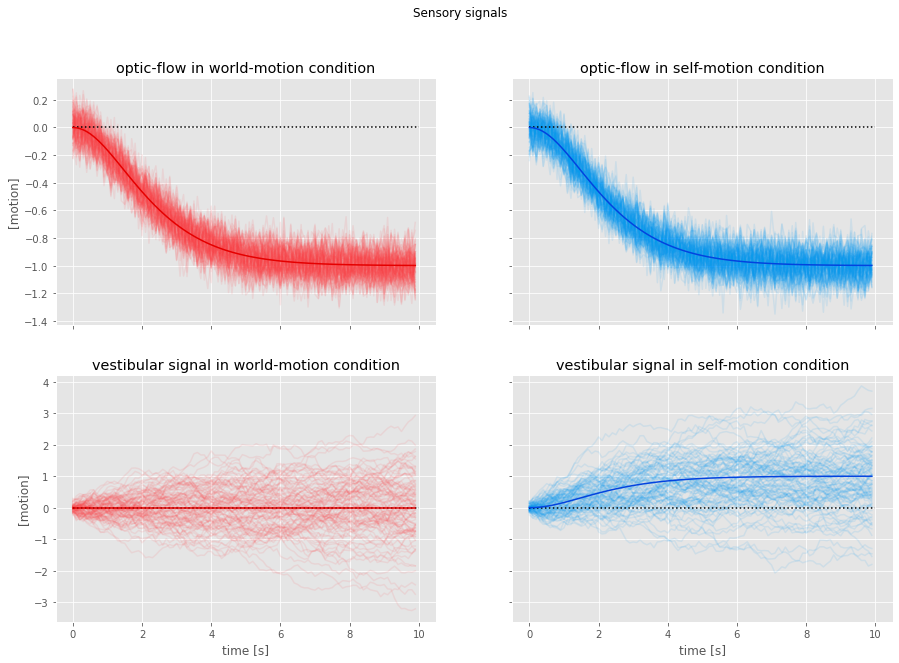

In [14]:
#@title Run to compare true signals to sensory data 
my_axes = my_plot_sensorysignals(judgments, opticflow, np.cumsum(vestibular*.1,axis=1), returnaxes=True, addaverages=False)

my_axes[0][0].plot(t, -v, color='xkcd:red')
my_axes[0][1].plot(t, -v, color='xkcd:blue')
my_axes[1][0].plot(t, np.zeros(100), color='xkcd:red')
my_axes[1][1].plot(t,  v, color='xkcd:blue')

plt.show()

The thick lines are the ground truth: the actual velocities in each of the conditions. With some effort, we can make out that _on average_ the vestibular signal does show the expected pattern after all. But there is also a lot of noise in the data.

### **TD 2.4**: Comparing sensory data to true signals

**Now answer the following:**

* How quickly do the sensory signals change, in other words how long (in s) does it take for the signal to change by a factor of 10 (1 order of magnitude)?
* How quickly does your perception and judgements change (order of magnitude, in sec)?  _Use your intuition_

**Background  Summary**:  

Now that we have examined the sensory signals, and understand how they relate to the ground truth. We see that there is enough information to _in principle_ disambiguate true self-motion from true world motion (there should be no illusion!). However, because the sensory information contains a lot of noise, i.e. it is unreliable, it could result in ambiguity.

**_It is time to refine our research question:_**

* Does the self-motion illusion occur due to unreliable sensory information?

# Micro-tutorial 3 - identify ingredients

Video available at https://youtube.com/watch?v=Xn9culHqZ7U


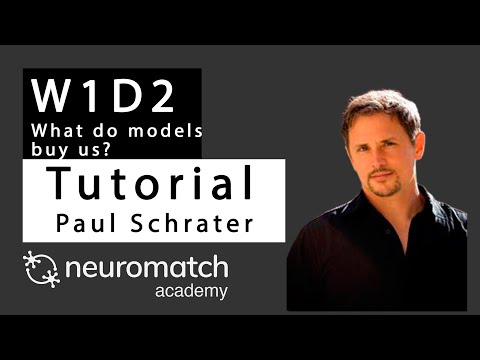

In [15]:
#@title Video: Ingredients
from IPython.display import YouTubeVideo
video = YouTubeVideo(id='Xn9culHqZ7U', width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)
video


**Goal**: think about what ingredients we will need for our model

We have access to sensory signals from the visual and vestibular systems. These are likely what the brain uses to estimate motion relative to ourselves and our self-motion.  

1. **We need some way to relate sensory signals to percepts**  
These are the key observations which help guide our thinking:

   _Sensory input can be noisy_: 
> We saw this specially with the vestibular signals.

   _Percepts are not as noisy as the sensory data_: 
> The brain regularly has to convert its sensory data into a more reliable and useful form. We don't experience illusory/false percepts that often.

 _In fact, percepts are fairly stable_:
>The experiment lasts 10 sec, and people are happy making only **one** judgment all that time.  

 Understanding how the brain reduces noise in sensory signals to form stable and accurate percepts is complex, but we can represent this process using a simple statistical model:  **time averaging the signal** 

 * Averaging reduces noise, smoothes signals and reduces timescale.  All these properties agree with our observation.

2. **We need a way to best determine if we are moving from our vestibular input**
 
 Although the vestibular sensory information is unreliable, the brain somehow uses it to decide if the body is moving. This suggests the brain may implement a thresholding mechanism, which suppresses small fluctuations in sensory signals unlikely to be real.  
 * Thresholding an averaged vestibular signal can help distinguish the no self-motion from self-motion. 


We will learn how to implement:
* _mean filter_ to smooth our sensory signals
* _threshold function_ to help distinguish moving from non-moving.  








One of the simplest models of noise reduction is a moving average over the recent past. 

That is, to get an estimate $\bar{s}(t)$ of a signal $s(t)$, we average over an interval of time of duration $w$ just preceding $t$:
$$ \bar{s}(t) = average(s[t-w, t])$$
which takes the average of all the signal points in between $t-w$ and $t$. Note that our estimate will be somewhat in the past (centered at $t-(w/2)$). 

This operation is a simple example of **filtering**, and is called a **moving average**, (sometimes: moving mean or rolling mean). 

The **parameter** $w$ is often termed the _window size_.

For more information on the moving average, check [this Wikipedia page](https://en.wikipedia.org/wiki/Moving_average)
______
 In this tutorial there is a simple running average function available:
 > `my_moving_window(s,w)`: 
     takes a signal time series $s$ and a window size $w$ as input. The window size is the number of samples (including the current one) over which an average is taken.

The code below picks one vestibular signal, integrates it to get a velocity estimate for self motion, and then filters it with several window sizes.



### **TD 3.1**: Understand the moving average function

**Play with the code**

Try different window sizes, then answer the following:

* What is the maximum window size? The minimum?
* Why are the larger window-size curves lower and shifted compared to the smaller $w$ curves? 
* How do the filtered estimates differ from the true signal?  

Modify the code to answer the following questions [IF TIME PERMITS]:
* Does the output change if you first filter and then integrate (reminder: here we integrated then filtered)?
* Would some other operation like maximum velocity do better than the average? (set FUN=np.max)

**Play with the moving average function**

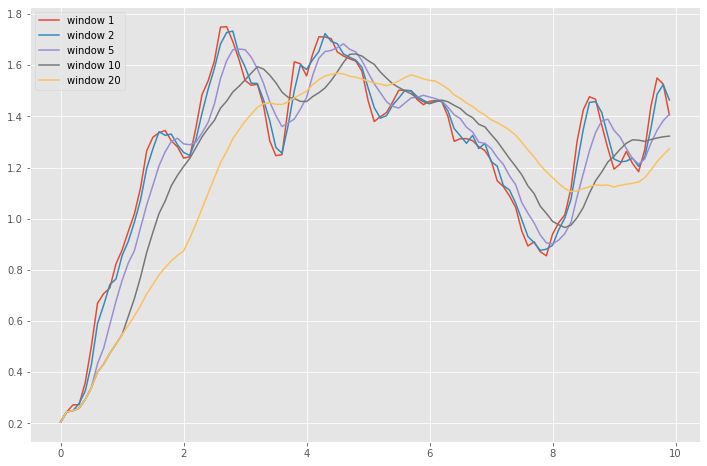

In [16]:
# Understanding the windowed average function
# filtering one signal:

# pick a trial number
trial_number = 100 # 100: first trial with self motion
one_signal = vestibular[trial_number,:]

# time on x-axis:
t = np.arange(0,10,.1)
# set up a figure
fig = plt.figure(figsize=(12,8))

######################################
# test various other window sizes here
for window in [1,2,5,10,20]:
    my_signal = one_signal
    # integrate:
    my_signal = np.cumsum(my_signal*.1)
    # filter:
    my_signal = my_moving_window(my_signal,
                                 window=window,
                                 FUN=np.mean)
    # plot
    plt.plot(t, 
             my_signal,
             label=f'window {window}')
    
# finish figure:
plt.legend()
plt.show()

_Note: the function `my_moving_window()` is defined in this notebook in the code block at at the top called "Convenience functions: Plotting and Filtering". It should be the first function there, so feel free to check how it works._

### **TD 3.2**: Thresholding the self-motion vestibular signal


We know that the vestibular signal is the only information available to estimate self motion, since the visual optic-flow signal is non-zero for both self and world motion. The mean integrated, filtered (accumulated) vestibular signals should be different between the two conditions (self-motion _or_ no self-motion). And the simplest way to decide if there was self motion or not, would be to use a threshold on those estimates of self motion. 

Here we:
* 1) Integrate the vestibular signal, and use a moving average filter. We then take the last value of the vestibular signal as our estimate of self-motion velocity. 
* 2) We sort these estimates separately for conditions of real world-motion vs. real self-motion. Remember that this information is stored in the first column of our experiment data matrix (true condition = judgments[:,0]). We end up with two estimates of self-motion velocity, one for each condition (v_nomove_est and v_move_est )
* 3) Transfor the two estimates of self-motion into binary (0,1) decisions by comparing them to a threshold. Remember the output of logical comparators (>=<) are logical (truth/1, false/0). 1 indicates we think there was self-motion and 0 indicates otherwise. YOUR CODE HERE.
* 4) We then check this 'classified' decision against the ground truth to determine 'classification' accuracy.
* 5) To understand how the threshold impacts classfication accuracy, we do 1-5  for a range of thresholds inside a for loop.

First we do 1-2. Then we do 3-implement the threshold and check our classification.
There are two lines of code to complete.


####**Estimate self-motion velocity from vestibular signal**

In [17]:
# Clean up vestibular signal and use it to estimate self-motion velocity.
# first we estimate self motion for all trials:
# using the velocity accumulated across 10 seconds of vestibular signal
v_ves = np.cumsum(vestibular*.1, axis=1);

# Use the last sample as the "judgment time"
# (the 100th sample has index 99: the 1st has index 0)
judgeT = 99
selfmotion_est = my_moving_window(v_ves,window=100,FUN=np.mean)[:,99]
# this line would use the max acceleration:
#selfmotion_est = my_moving_window(vestibular,window=100,FUN=np.max)[:,99]*10


# Now we separate the trials by condition
# no-move: judgments ==0 is the "world-motion" condition where there is no self-motion signal
# move:    judgments ==1 is the "self-motion" condition with a self-motion signal
v_nomove_est = selfmotion_est[np.where(judgments[:,0]==0)]
v_move_est  = selfmotion_est[np.where(judgments[:,0]==1)]
# and we get the number of trials:
nomove_n, move_n = len(v_nomove_est), len(v_move_est)

####**Threshold self-motion velocity into binary classifiction of self-motion**

In [18]:
#### Then we define and implement the threshold (fill in below!!)
# for various thresholds:
thresholds = np.arange(-.5,1.501,.001)
# as well as the proportion classified correctly:
prop_correct = np.empty(thresholds.shape)
pselfmove_nomove = np.empty(thresholds.shape)
pselfmove_move = np.empty(thresholds.shape)


def threshold_classify(thresholds,pselfmove_nomove,pselfmove_move):


  #uncomment below, and fill in your code

  ## this loops through all the threshold values we're investigating:
  #for thr_i, threshold in enumerate(thresholds):

      ##############################################################
      # compare the two self motion estimates to the threshold:
        
      ## 1: for v_nomove_est
      #is_move = (...)  # YOUR CODE HERE. should return true or false.
      #pselfmove_nomove[thr_i] = np.sum(is_move)/nomove_n;
      
      ## 2: for v_move_est
      #is_move = (...)  #YOUR CODE HERE. should return true or false.
      #pselfmove_move[thr_i] = np.sum(is_move)/move_n;
      
      ##############################################################

      ## calculate the proportion classified correctly: (1-pselfmove_nomove) + () 
      ## Correct rejections:
      #p_CR = (1-pselfmove_nomove[thr_i]);
      ## correct detections:
      #p_D = pselfmove_move[thr_i];
      
      ## this is corrected for proportion of trials in each condition:
      #prop_correct[thr_i] = ((p_CR * nomove_n) + (p_D * move_n)) / (nomove_n + move_n)
      ## the simpler line might just be:
      ##prop_correct[thr_i] = (p_CR + p_D) / 2

  # comment this out when you've filled
  raise NotImplementedError("Student excercise: threshold and classify")

  return prop_correct

##call the function to get classification accuracy for various threshold
#prop_correct = threshold_classify(thresholds,pselfmove_nomove,pselfmove_move)
## this plots the results for various thresholds:
#my_plot_thresholds(thresholds, pselfmove_nomove, pselfmove_move, prop_correct)

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/master//tutorials/W1D2_ModelingPractice/solutions/W1D2_Tutorial1_Solution_50b86d87.py)

*Example output:*

<img alt='Solution hint' align='left' width=739 height=519 src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/tutorials/W1D2_ModelingPractice/static/W1D2_Tutorial1_Solution_50b86d87_0.png>



Let's unpack this plot: 

Ideally, the blue line representing our estimate of self-motion when there was true self-motion should be a flat line at 1 (although we know it's dependent on the threshold because it's a noisy signal). The orange line representing our estimate of self-motion when there was NOT true self-motion, should ideally be a flat line at 0. So for real noisy sensory data, our estimates our not perfect.

For low-thresholds, we always judge that there was self-motion. Which makes sense because the vestibular signal is noisy so we need to have a high threshold so we don't detect noise. But if we set the threshold too hight, that's not good either because we misjudge that there was no self-motion when in reality there was. The ideal threshold is somewhere between these two extremes. This threshold-dependent trade-off between correct detections and correct rejection is a hallmark of signal detection theory:

Trials from the world-motion condition classified as having self motion, are incorrect, so we want that percentage low. Trials from the self-motion condition should be classified as having self motion, so we want that percentage high. It seems that the optimum threshold is around 0.33 m/s.

The ingredients we have collected for our model so far:
* integration: get the vestibular signal in the same unit as the visual signal
* running average: accumulate evidence over some time, so that perception is stable
* decision if there was self motion (threshold)

Since the velocity judgments are made at the end of the 10 second trials, it seems reasonable to use the sensory signals at the last sample to estimate what percept the participants said they had. 

# Micro-tutorial 4 - formulating a hypotheses

Video available at https://youtube.com/watch?v=SxMeDSB6ujs


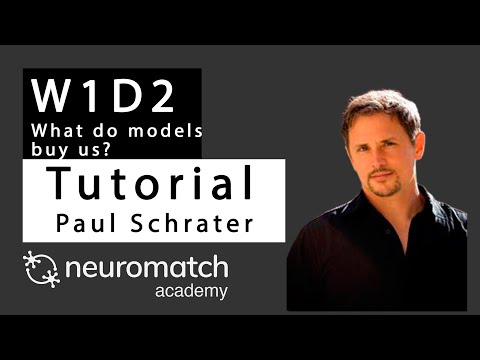

In [20]:
#@title Video: Hypothesis
from IPython.display import YouTubeVideo
video = YouTubeVideo(id='SxMeDSB6ujs', width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)
video


**Goal**: formulate reasonable hypotheses in mathematical language using the ingredients identified in step 3. Write hypotheses as a function that we evaluate the model against later...

**Question:** _Why do we experience the illusion?_

We've seen this has two ingredients.  
* Optic flow is ambiguous: both world motion and self-motion drive visual motion
* Vestibular signals _can_ be ambiguous when they are noisy. 

What are the relationships between sensory signals and the world motion? 

**Optic flow**

Why is optic flow an ambiguous cue to world motion and self-motion?  Let's make this more precise by formalizing the relationships between these quantities. Let's introduce some notation:


> $s_{visual}$: optic flow signal
>
> $w_v$:   world motion (velocity magnitude)
>
> $s_v$: self motion (velocity magnitude)

> Note that $s_{visual}$ and $s_v$ will always have opposite signs. As you move forward through the world (+$s_v$), the image of the world on your eye ball (optic flow) moves backwards ($-s_{visual}$).
>
> $$s_{visual} = w_v - s_v + noise$$

> You can intuit this by imagining that you're running along a train, at the same exact speed as the train. The image of the train on your eyeball will not change, because the world motion (train) is cancelled out by your self-motion.

**Vestibular**

Vestibular is similar but simpler.  It can be ambiguous, but only due to noise.

> $s_{vestibular}$: vestibular signal
>
> $$s_{vestibular} = s_v + noise$$

**Combining Relationships**

Without the sensory noise, these two relations are two linear equations, with two unknowns!

This suggests the brain could simply "solve" for $s_v$ and $w_v$.  

However, given the noisy signals, sometimes these solutions will not be correct.  Perhaps that is enough to explain the illusion?


###**TD 4.1** Write out Hypothesis

Use the discussion and framing to write out your hypothesis in the form:
> Illusory self-motion occurs when (give preconditions).  We hypothesize it occurs because (explain how our hypothesized relationships work)

* **SAMPLE ANSWER** Illusory self-motion occurs when noisy vestibular sensing falsely detects self-movement. We hypothesize it occurs because the brain perceives world motion through the optic flow signal after removing self-motion, using the relationship $w_v = s_{visual} + s_v$. Since $s_{visual}$ and $s_v$ always have opposite signs, these should cancel out when there is perceived self-motion.

### **TD 4.2** Relate hypothesis to ingredients

Now it's time to pull together the ingredients and relate them to our hypothesis.  

**For each trial we have:**

| variable | description |
| ---- | ---- |
| $\hat{v_s}$ | **self motion judgment** (in m/s)|
| $\hat{v_w}$ | **world motion judgment** (in m/s)|
|  $s_{ves}$ | **vestibular info** filtered and integrated vestibular information  |
|  $s_{opt}$ | **optic flow info** filtered optic flow estibular information  |
| $z_s$ | **Self-motion detection** boolean value (True/False) indicating whether the vestibular info was above threshold or not |

Answer the following questions by replotting your data and ingredients: 

* which of the 5 variables do our hypothesis say should be related?
* what do you expect these plots to look like?  

 

In [21]:
#@title Run to calculate variables
# these 5 lines calculate the main variables that we might use in the model
s_ves = my_moving_window(np.cumsum(vestibular*.1, axis=1),window=100)[:,99]
s_opt = my_moving_window(opticflow,50)[:,99]
v_s = s_ves
v_w = -s_opt - v_s
z_s = (s_ves > 0.33)

Below is a generic template to compare distributions of variables. For example, how variable are the estimates of velocity we get from each of the sensory signals?

**Plot histograms**

In [22]:
# Plot histograms

#uncomment below and fill in with your code

#plt.figure(figsize=(8,6))
#####################################
## determine which variables you want to look at, replace question marks

#plt.hist(???, label='a', alpha=0.5) # YOUR CODE HERE
#plt.hist(???, label='b', alpha=0.5) # YOUR CODE HERE

# change labels if you need them
#####################################

#plt.legend(facecolor='xkcd:white')
#plt.show()

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/master//tutorials/W1D2_ModelingPractice/solutions/W1D2_Tutorial1_Solution_4ba396ff.py)

*Example output:*

<img alt='Solution hint' align='left' width=489 height=367 src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/tutorials/W1D2_ModelingPractice/static/W1D2_Tutorial1_Solution_4ba396ff_0.png>



Below is generic code to create scatter diagrams. Use it to see if the relationships between variables are the way you expect them. For example, what is the relationship between the estimates of self motion and world motion, as we calculate them here?

**Scatter plots**

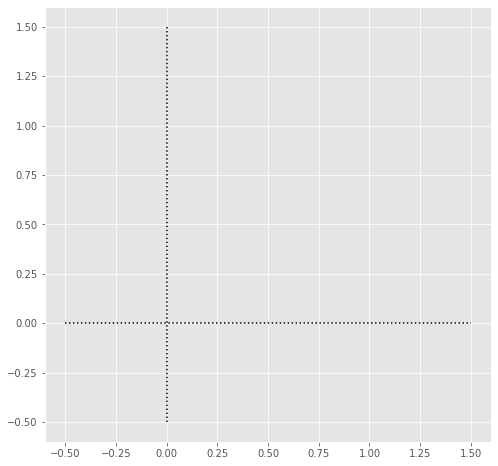

In [24]:
# Template for scatter plot

# this sets up a figure with some dotted lines on y=0 and x=0 for reference
plt.figure(figsize=(8,8))
plt.plot([0,0],[-0.5,1.5],':',color='xkcd:black')
plt.plot([-0.5,1.5],[0,0],':',color='xkcd:black')

#############################################################################
#uncomment below and fill in with your code
## determine which variables you want to look at (replace question marks)
#plt.scatter(???,     # variable on the abscissa / x-axis 
#            ???)     # variable on the ordinate / y-axis
#plt.xlabel('a') # change axis labels if you need reminders
#plt.ylabel('b')
#plt.show()

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/master//tutorials/W1D2_ModelingPractice/solutions/W1D2_Tutorial1_Solution_b67a48c4.py)

*Example output:*

<img alt='Solution hint' align='left' width=521 height=498 src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/tutorials/W1D2_ModelingPractice/static/W1D2_Tutorial1_Solution_b67a48c4_0.png>



Below is code that uses $z_s$ to split the trials in into two categories (i.e. $s_{ves}$ below or above threshold) and plot the mean in each category.

**Split variable means bar graph**

In [26]:
# Split mean bar graph
################################################
#uncomment below and fill in with your code

## fill in the source variable you want to check:
#source_var = ???

#below = np.mean( source_var[np.where(np.invert(z_s))[0]] )
#above = np.mean( source_var[np.where(z_s)[0]] )

#plt.figure()
#plt.bar(x=[0,1],height=[below,above])
#plt.xticks([0,1],['below','above'])
#plt.show()

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/master//tutorials/W1D2_ModelingPractice/solutions/W1D2_Tutorial1_Solution_587560e9.py)

*Example output:*

<img alt='Solution hint' align='left' width=716 height=475 src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/tutorials/W1D2_ModelingPractice/static/W1D2_Tutorial1_Solution_587560e9_0.png>



# Micro-tutorial 5 - toolkit selection

Video available at https://youtube.com/watch?v=HQjMU3TXvyY


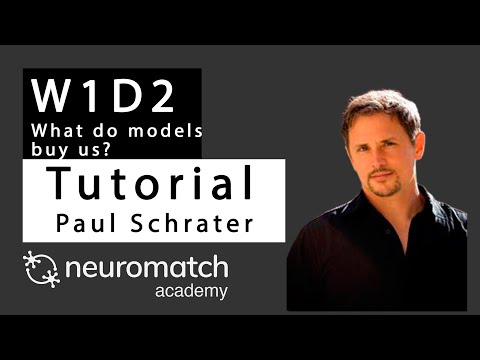

In [28]:
#@title Video: Toolkit
from IPython.display import YouTubeVideo
video = YouTubeVideo(id='HQjMU3TXvyY', width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)
video


**Goal**: with the question, ingredients and hypotheses in mind, which toolkit (modeling approach) would be best to use?

## Toolkits

The lecture covers the notion of toolkit.  Here we explain the toolkit we use in our simulation.

**Simulation as a generic tool** 

Because our data provides per trial data of both inputs and outputs, designing a _simulation_ is a powerful method.  

In general, simulation models have a typical structure:

![Generic Simulation](https://i.ibb.co/y8j7Y9C/Copy-of-W1-D2-Tutorials-micro-lectures.jpg)


Simulation models have:

* **inputs** including input variables, _and_ the ingredients needed to build the simulation functions.
* **simulation** which runs the model _many times_ on the inputs, over a range of scenarios (typically different parameter or model choices).  

 In addition, many simulations run _replications_, which are useful if components of your input or model are _stochastic_.
* **outputs** the output variables.  these may have replicas if the simulations are repeated to account for stochastic elements, which are perfect for statistical analysis.


_____
The elements of a simulation model are quite generic and occur in most models.  The most important considerations in deciding a toolkit are: 
* What types of mechanisms (causes, processes, systems) will you need to consider in your model?
* What aspects of the data and ingredients are _essential_ which are clearly _irrelevant_, and which can be abstracted over.

These considerations are completely determined by your research question.  To better understand this, we will engage you in a TA-led discussion.

### **TD 5.1** Here we will have a TA-guided discussion about how questions drive toolkit selection.  


NOTES:   [See slides:](https://docs.google.com/presentation/d/1jn5YyzNqUJloi42TaUDpwXnnU_EI9OJxClvd4s1ismM/edit?usp=sharing)

1. **DISCUSS MECHANISMS/INGREDIENTS NEEDED FOR QUESTIONS: what kinds of mechanisms and ingredients are needed for the discussion questions**

2. **DISCUSS WHAT INGREDIENTS DONT MATTER: simulation / level of abstraction (depends on what is measured & is irrelevant to the question)**





# Break

# Reading

Blohm G, Kording KP, Schrater PR (2020). _A How-to-Model Guide for Neuroscience_ eNeuro, 7(1) ENEURO.0352-19.2019. https://doi.org/10.1523/ENEURO.0352-19.2019 

Dokka K, Park H, Jansen M, DeAngelis GC, Angelaki DE (2019). _Causal inference accounts for heading perception in the presence of object motion._ PNAS, 116(18):9060-9065. https://doi.org/10.1073/pnas.1820373116

Drugowitsch J, DeAngelis GC, Klier EM, Angelaki DE, Pouget A (2014). _Optimal Multisensory Decision-Making in a Reaction-Time Task._ eLife, 3:e03005. https://doi.org/10.7554/eLife.03005

Hartmann, M, Haller K, Moser I, Hossner E-J, Mast FW  (2014). _Direction detection thresholds of passive self-motion in artistic gymnasts._ Exp Brain Res, 232:1249–1258. https://doi.org/10.1007/s00221-014-3841-0

Mensh B, Kording K (2017). _Ten simple rules for structuring papers._ PLoS Comput Biol 13(9): e1005619. https://doi.org/10.1371/journal.pcbi.1005619

Seno T, Fukuda H (2012). _Stimulus Meanings Alter Illusory Self-Motion (Vection) - Experimental Examination of the Train Illusion._ Seeing Perceiving, 25(6):631-45. https://doi.org/10.1163/18784763-00002394
